In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import wikipedia as wp
import yfinance as yf
import talib

### S&P 500 stocks

In [8]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head()

,Name,Sector
Symbol,,
AAPL,Apple Inc.,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe Inc.,Information Technology


### Get the Fundamentals

In [9]:
fundamentals = [
	yf.Ticker(stock).info for stock in stocks.index
]
fundamentals = pd.DataFrame(fundamentals).set_index("symbol")
fundamentals.index = fundamentals.index.rename("Symbol")  # for consistency with the stocks dataframe
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,3794670190592,41.289474,30.201607,66.641890,6.08,8.31,3.767,0.1612,1.240,0.62,0.266680,47292590,9.730,0.23971
ABBV,303294251008,59.593750,14.106537,50.287136,2.88,12.13,3.413,2.1359,0.613,4.13,0.130035,5952693,6.671,0.09223
ABT,195334897664,34.231003,21.826132,4.908473,3.29,5.16,22.944,0.6565,0.722,1.65,0.049232,5064692,4.953,0.13992
ACN,223111086080,31.211540,25.492323,7.892224,11.44,14.07,45.242,0.4510,1.245,1.36,0.049232,2471022,3.453,0.11194
ADBE,203165499392,37.401134,20.021439,14.120544,12.34,20.55,32.685,0.0000,1.299,0.12,-0.222723,3254041,11.488,0.25588


In [10]:
# Normalised the data
normalized_fundamentals = (fundamentals - fundamentals.mean()) / fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,5.012003,0.011684,0.070928,2.443345,-0.218927,-0.209777,-0.100823,-0.212191,0.713554,-1.017199,0.181614,1.271806,0.884289,0.653144
ABBV,-0.120958,0.190301,-0.214429,1.721942,-0.412829,-0.033784,-0.100832,0.372491,-0.923289,1.050662,-0.248670,-0.261666,0.299419,-0.484589
ABT,-0.279678,-0.057194,-0.077565,-0.279694,-0.387985,-0.354902,-0.100385,-0.065539,-0.638734,-0.410391,-0.503112,-0.294606,-0.029056,-0.116685
ACN,-0.238842,-0.086659,-0.012565,-0.148082,0.105858,0.055594,-0.099875,-0.126385,0.726606,-0.581240,-0.503112,-0.390816,-0.315851,-0.332536
ADBE,-0.268165,-0.026259,-0.109561,0.126647,0.160393,0.354138,-0.100162,-0.259920,0.867579,-1.311766,-1.359475,-0.361771,1.220413,0.777887


In [11]:
# Save it to a csv file
normalized_fundamentals.to_csv("../data/SP100/fundamentals.csv")

### Historical data

In [12]:
# 获取股票历史数据
values = [
    yf.Ticker(stock).history(period="5y", actions=False) for stock in stocks.index
]

# 遍历每只股票数据并计算特征
for idx, stock_values in enumerate(values):
    # 标准化收盘价
    stock_values["NormClose"] = (stock_values["Close"] - stock_values["Close"].mean()) / stock_values["Close"].std()
    
    # 计算对数收益率
    stock_values["DailyLogReturn"] = np.log(1 + stock_values["Close"].pct_change())
    stock_values["ALR1W"] = stock_values["DailyLogReturn"].rolling(window=5).sum() * 5
    stock_values["ALR2W"] = stock_values["DailyLogReturn"].rolling(window=10).sum() * 5
    stock_values["ALR1M"] = stock_values["DailyLogReturn"].rolling(window=21).sum() * 21
    stock_values["ALR2M"] = stock_values["DailyLogReturn"].rolling(window=42).sum() * 21
    
    # 标准化累计收益率和对数收益率
    stock_values["DailyLogReturn"] /= stock_values["DailyLogReturn"].std()
    stock_values["ALR1W"] /= stock_values["ALR1W"].std()
    stock_values["ALR2W"] /= stock_values["ALR2W"].std()
    stock_values["ALR1M"] /= stock_values["ALR1M"].std()
    stock_values["ALR2M"] /= stock_values["ALR2M"].std()
    
    # 使用TA-Lib计算RSI
    stock_values["RSI"] = talib.RSI(stock_values["Close"], timeperiod=14) / 100
    
    # 使用TA-Lib计算MACD
    macd, macd_signal, macd_hist = talib.MACD(stock_values["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    stock_values["MACD"] = macd
    
    # 使用TA-Lib计算Momentum和Volatility
    stock_values['Momentum'] = talib.MOM(stock_values['Close'], timeperiod=90)
    stock_values['Volatility'] = talib.STDDEV(stock_values['Close'], timeperiod=30, nbdev=1) * np.sqrt(252)
    
    # 删除无关列
    stock_values.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)

# 合并所有股票数据并去除缺失值
values = pd.concat(values, keys=stocks.index).dropna()

# 显示前10行数据
print(values.head(n=10))

                                      Close  NormClose  DailyLogReturn  \
Symbol Date                                                              
AAPL   2020-04-28 00:00:00-04:00  67.679855  -1.991534       -0.819888   
       2020-04-29 00:00:00-04:00  69.902809  -1.938323        1.621364   
       2020-04-30 00:00:00-04:00  71.377480  -1.903023        1.047382   
       2020-05-01 00:00:00-04:00  70.228363  -1.930530       -0.814270   
       2020-05-04 00:00:00-04:00  71.222000  -1.906745        0.704866   
       2020-05-05 00:00:00-04:00  72.290962  -1.881157        0.747403   
       2020-05-06 00:00:00-04:00  73.036812  -1.863304        0.514970   
       2020-05-07 00:00:00-04:00  73.792381  -1.845217        0.516347   
       2020-05-08 00:00:00-04:00  75.548752  -1.803175        1.180138   
       2020-05-11 00:00:00-04:00  76.737534  -1.774719        0.783296   

                                     ALR1W     ALR2W     ALR1M     ALR2M  \
Symbol Date                        

In [13]:
# Save the dataframe "values" to cvs file
values.to_csv("../data/SP100/values.csv")

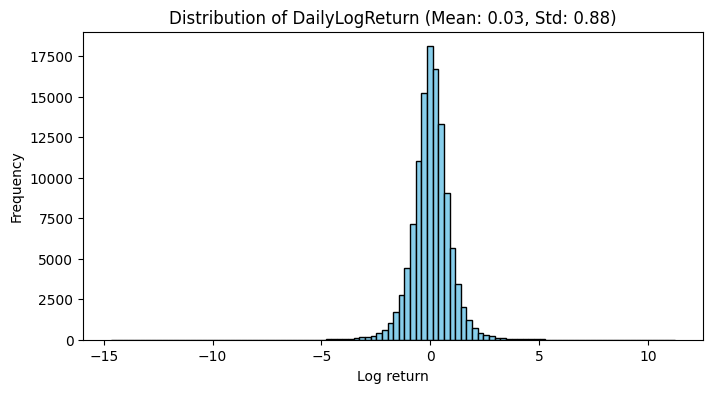

In [14]:
plt.figure(figsize=(8, 4))

column = "DailyLogReturn"
plt.hist(values[column], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

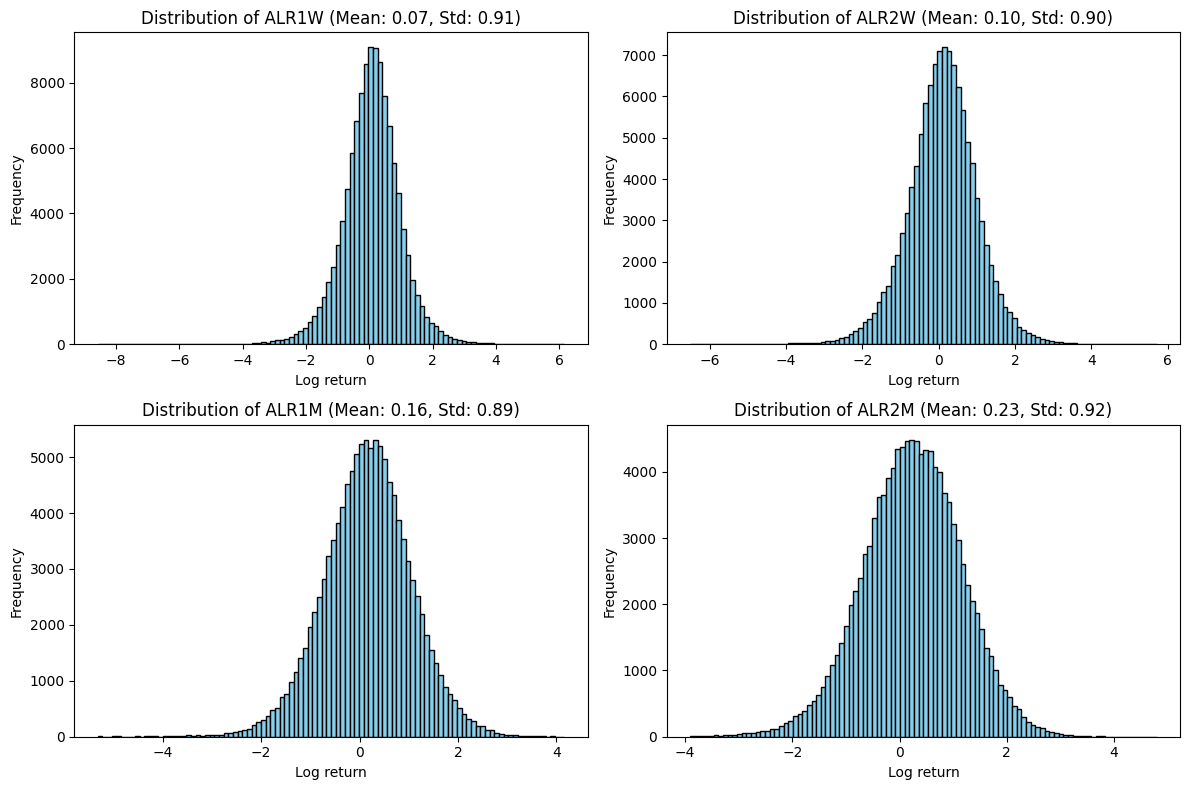

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, column in enumerate(["ALR1W", "ALR2W", "ALR1M", "ALR2M"]):
	ax = axs[idx // 2, idx % 2]
	ax.hist(values[column], bins=100, color="skyblue", edgecolor="black")
	ax.set_title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
	ax.set_xlabel("Log return")
	ax.set_ylabel("Frequency")
	
plt.tight_layout()
plt.show()

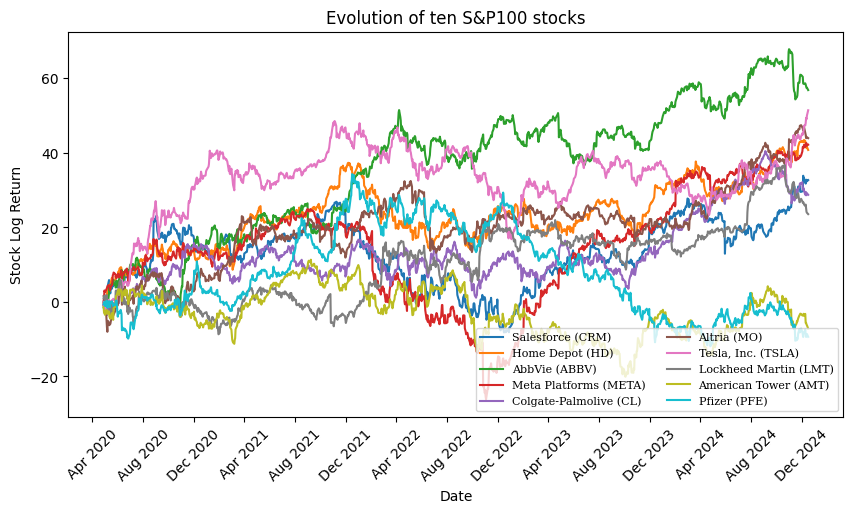

In [16]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumsum(values.loc[stock]["DailyLogReturn"]), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten S&P100 stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8, 'family': 'serif'})
plt.show()